In [1]:
import sys
import os
sys.path.append('..')
os.chdir('..')

import torch
from torch.optim import Adam

from model.loss import Loss
from model.metrics import Accuracy
from utils.util import initModel, timer, SDF

from dataset.data_loaders import getDataloaders
from dataset.data_prepare import generate_sdms, get_tts

import matplotlib.pyplot as plt

from configs import CONF

import wandb

In [2]:
wandb.login()
imIDs = get_tts()
generate_sdms(imIDs)

print(f'[INFO] MODEL: {CONF.MODEL}, DATASET: {CONF.DSET}, LOSS: {CONF.LOSS}')

trainLoader, testLoader = getDataloaders(CONF, CONF.DEFAULT_DEVICE, imIDs)
model = initModel(CONF.DEFAULT_DEVICE)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CONF.INIT_LR, weight_decay=1e-5)

wandb.init(project=CONF.MODEL,
    name=CONF.RUN_ID, 
    config=CONF)

for epoch in range(CONF.NUM_EPOCHS):
    ts = timer(epoch)
  
    model.train()
    acc = Accuracy()
    lss = Loss()
    for source, gt_mask, gt_sdm in trainLoader:
        source, gt_mask, gt_sdm = source.to(CONF.DEFAULT_DEVICE), gt_mask.to(CONF.DEFAULT_DEVICE), gt_sdm.to(CONF.DEFAULT_DEVICE)

        logits = model(source)
        loss = lss.update(epoch, logits, gt_mask, gt_sdm)
        acc.update(logits, gt_mask, gt_sdm)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    trainLoss = lss.compute_avg(trainLoader.__len__())
    trainSegAcc = acc.compute_avg(trainLoader.__len__())

    dt, etc = timer(epoch, ts)
    
    print(f"[{CONF.DEFAULT_DEVICE}] Epoch {epoch + 1}/{CONF.NUM_EPOCHS} | dt: {dt}s :: {etc}m")
    print(f"Train -> loss: {trainLoss:.4f} | DSC: {trainSegAcc['dsc']:.4f} | JCC: {trainSegAcc['iou']:.4f} | HD95: {trainSegAcc['hd95']:.4f} | ASD: {trainSegAcc['asd']:.4f} |")
    print("--------------------------------------------------------------------------------")

    wandb.log({'loss/train': trainLoss, 'metrics/DSC-train': trainSegAcc['dsc'], 'metrics/JCC-train': trainSegAcc['iou'], 
               'metrics/HD95-train': trainSegAcc['hd95'], 'metrics/ASD-train': trainSegAcc['asd'],}, step = epoch+1)
    
wandb.finish()
        

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: oleksii-martynchuk (oleksii-martynchuk-german-aerospace-center-dlr). Use `wandb login --relogin` to force relogin


[INFO] found 694 examples in the training set...
[INFO] found 77 examples in the test set...
[PROC] SDMs >>> ready
[INFO] MODEL: UNet, DATASET: scarp, LOSS: sdm_DICE


[cuda:0] Epoch 1/150 | dt: 10.0s :: 25.0m
Train -> loss: 0.3516 | DSC: 0.7603 | JCC: 0.6207 | HD95: 0.8045 | ASD: 0.4804 |
--------------------------------------------------------------------------------
[cuda:0] Epoch 2/150 | dt: 7.0s :: 17.0m
Train -> loss: 0.2695 | DSC: 0.8073 | JCC: 0.6811 | HD95: 0.7888 | ASD: 0.5392 |
--------------------------------------------------------------------------------
[cuda:0] Epoch 3/150 | dt: 7.0s :: 17.0m
Train -> loss: 0.2476 | DSC: 0.8182 | JCC: 0.6957 | HD95: 0.7738 | ASD: 0.5467 |
--------------------------------------------------------------------------------
[cuda:0] Epoch 4/150 | dt: 7.0s :: 17.0m
Train -> loss: 0.2456 | DSC: 0.8133 | JCC: 0.6924 | HD95: 0.7686 | ASD: 0.5558 |
--------------------------------------------------------------------------------
[cuda:0] Epoch 5/150 | dt: 7.0s :: 17.0m
Train -> loss: 0.2325 | DSC: 0.8206 | JCC: 0.7002 | HD95: 0.7490 | ASD: 0.5584 |
-----------------------------------------------------------------

loss/train,█▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
metrics/ASD-train,▁▃▃▆▇█▇▇▇▇▇▇▇▇▆▆▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▆▅▆▄▅
metrics/DSC-train,▁▁▃▃▃▄▄▄▄▅▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
metrics/HD95-train,█▇▄▅▅▆▅▄▄▄▄▃▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▃▂▃▃▂▂▃▂▃▃▃▁▂
metrics/JCC-train,▁▁▃▃▃▄▄▄▄▄▄▅▅▅▅▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████
loss/train,0.05167
metrics/ASD-train,0.57025
metrics/DSC-train,0.94895
metrics/HD95-train,0.70714
metrics/JCC-train,0.90411


In [23]:
logits[0][0].min()

tensor(-8.8856, device='cuda:0', grad_fn=<MinBackward1>)

In [24]:
pred_mask = torch.sigmoid(1000*logits)
pred_sdm = torch.tanh(logits)
# pred_sdm = SDF(pred_mask)

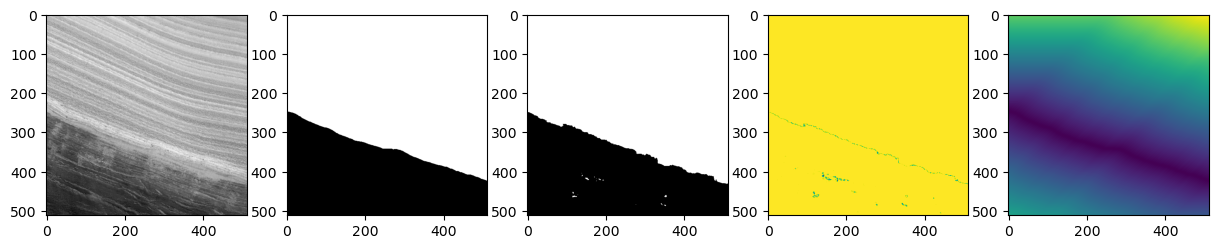

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
id = 3
axs[0].imshow(source[id][0].cpu().detach().numpy(), cmap ='gray')
axs[1].imshow(gt_mask[id][0].cpu().detach().numpy(), cmap ='gray')
axs[2].imshow(pred_mask[id][0].cpu().detach().numpy(), cmap ='gray')
axs[3].imshow(torch.abs(pred_sdm[id][0]).cpu().detach().numpy(), cmap ='viridis')
axs[4].imshow(torch.abs(gt_sdm[id][0]).cpu().detach().numpy(), cmap ='viridis')

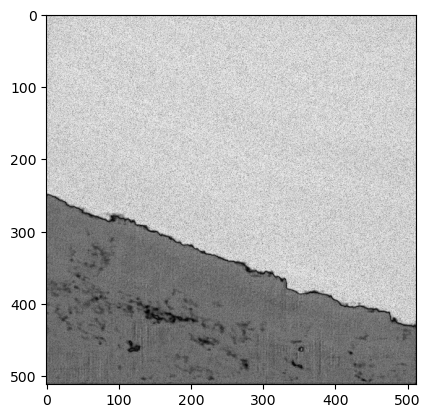

In [30]:
plt.imshow(torch.abs(logits[id][0]).cpu().detach().numpy(), cmap ='gray')